In [224]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
from datetime import datetime, timedelta
import pytz
import pandas_market_calendars as mcal
import alphalens as al

In [225]:
df = pd.read_csv("default_present_subset.csv")

In [226]:
print(df.columns)


Index(['default_present', 'default_impact', 'default_mentioned',
       'default_sentiment', 'index', 'summary', 'description', 'Ticker',
       'Sector', 'Industry', 'Company', 'pubDate', 'pubDate_brief',
       'pubDate.1', 'categories', 'content', 'title', 'relationship_type',
       'financial_entities', 'extracted_tickers_summary',
       'extracted_tickers_description', 'extracted_tickers_financial_entities',
       'relevant_companies', 'sentiment_score'],
      dtype='object')


In [340]:
columns_to_load = ['Ticker', 'pubDate', 'sentiment_score']
df = pd.read_csv("revenue_present_subset.csv", usecols=columns_to_load)

In [341]:
display(df)

,Ticker,pubDate,sentiment_score
0,MET,2022-10-31T20:36:25+00:00,-9.998440e-01
1,KO,2023-05-04T23:39:33+00:00,6.053858e-05
2,KMI,2023-03-06T10:58:14+00:00,-1.333524e-07
3,PKG,2023-05-26T18:02:31+00:00,-9.393094e-08
4,FDX,2022-10-03T19:23:58+00:00,9.991229e-01
...,...,...,...
1271,DRI,2023-06-23T18:50:25+00:00,3.017823e-05
1272,SBNY,2023-03-17T09:13:43+00:00,9.901447e-01
1273,LMT,2022-10-18T11:58:00+00:00,9.595270e-01
1274,ABBV,2023-05-24T11:00:00+00:00,8.262470e-01


## Data Preprocessing

### Adjusting the dates of news articles

In [342]:
df['pubDate'] = pd.to_datetime(df['pubDate'], errors='coerce')

nyse = mcal.get_calendar('NYSE')

trading_start_hour = 9
trading_start_minute = 30
trading_end_hour = 16
trading_end_minute = 0

def adjust_date(pub_date):
    if pd.isnull(pub_date) or not isinstance(pub_date, pd.Timestamp):
        return pub_date

    trading_end_time = pd.Timestamp(f'{pub_date.date()} {trading_end_hour}:{trading_end_minute}')
    if pub_date >= trading_end_time:
        next_trading_day = nyse.schedule(start_date=pub_date.date() + pd.DateOffset(days=1), end_date=pub_date.date() + pd.DateOffset(days=10)).iloc[0]['market_open']
        return next_trading_day
    else:
        valid_days = nyse.valid_days(start_date=pub_date.date(), end_date=pub_date.date())
        if not valid_days.empty and pub_date.date() == valid_days[0].date():
            return pub_date
        else:
            next_trading_day = nyse.schedule(start_date=pub_date.date() + pd.DateOffset(days=1), end_date=pub_date.date() + pd.DateOffset(days=10)).iloc[0]['market_open']
            return next_trading_day

df['pubDate'] = df['pubDate'].apply(adjust_date)

TypeError: Cannot compare tz-naive and tz-aware timestamps

### Converting probabiltiies to one value

In [343]:
import ast

def convert_sentiment_to_score(predicted_sentiment_str):
    predicted_sentiment_probabilities = ast.literal_eval(predicted_sentiment_str)
    
    positive = predicted_sentiment_probabilities['positive']
    negative = predicted_sentiment_probabilities['negative']
    
    difference = positive - negative
    
    if positive >= negative:
        max_value = positive
    else:
        max_value = -negative
    
    sentiment_score = (difference + max_value) / 2
    
    return sentiment_score

df['Sentiment_Score'] = df['predicted_sentiment_probabilities'].apply(convert_sentiment_to_score)

df.head(10)

KeyError: 'predicted_sentiment_probabilities'

### Replacing tickers

In [344]:
df['pubDate'] = pd.to_datetime(df['pubDate'], utc=True, errors='coerce')
df['pubDate'] = df['pubDate'].dt.date

print(df['pubDate'].dtypes)

replacements = {
    'ATVI': 'ATVIX',
    'ABC': 'ABG',
    'FBHS': '2FB.BE',
    'FISV': 'FISV.VI',
    'FRC': 'FRCB',
    'NLOK': 'SYM.MU',
    'PKI': 'PKN.SG',
    'RE': 'ERE.SG',
    'SIVB': 'SIVBQ',
}

df['Ticker'] = df['Ticker'].replace(replacements)

df = df[df['Ticker'] != 'SBNY'] 
df.head(10)

object


,Ticker,pubDate,sentiment_score
0,MET,2022-10-31,-9.998440e-01
1,KO,2023-05-04,6.053858e-05
2,KMI,2023-03-06,-1.333524e-07
3,PKG,2023-05-26,-9.393094e-08
4,FDX,2022-10-03,9.991229e-01
5,SBAC,2022-11-29,-1.541285e-02
6,FSLR,2023-06-05,-9.696936e-01
7,PG,2023-03-10,9.902040e-01
8,WMT,2023-07-28,-8.342230e-05
9,NDAQ,2022-10-30,9.978120e-01


### Filtering the dates (OPTIONAL - Left the percentage at 0 for now)

In [345]:
# df['pubDate'] = pd.to_datetime(df['pubDate'])

# df['pubDate'] = pd.to_datetime(df['pubDate'])
# total_tickers = df['Ticker'].nunique()

# percentage = 0
# threshold = total_tickers * percentage

# df.sort_values('pubDate', inplace=True)

# ticker_counts_by_date = {}

# for date in df['pubDate'].unique():
#     tickers_with_scores = df[df['pubDate'] <= date]['Ticker'].nunique()
#     ticker_counts_by_date[date] = tickers_with_scores

# ticker_counts_df = pd.DataFrame(list(ticker_counts_by_date.items()), columns=['Date', 'TickerCount'])

# earliest_date = ticker_counts_df[ticker_counts_df['TickerCount'] >= threshold]['Date'].min()

# #print(f"Earliest date with sentiment scores for at least {percentage} of the tickers: {earliest_date}")

# df = df[df['pubDate'] >= earliest_date]

### Aggregating scores (Signal) per day

In [346]:
aggregated_data = df.groupby(['Ticker', 'pubDate'])['sentiment_score'].mean().reset_index()
aggregated_data

,Ticker,pubDate,sentiment_score
0,AAL,2022-10-27,-0.999969
1,AAL,2022-12-06,0.993678
2,AAL,2023-02-03,0.994685
3,AAL,2023-02-27,-0.674010
4,AAL,2023-04-04,-0.021811
...,...,...,...
1100,XOM,2023-03-10,-0.999903
1101,XOM,2023-04-04,-0.991926
1102,XOM,2023-08-01,0.000241
1103,XYL,2022-10-13,-0.890320


### Converting the datatime back to UTC and indexing for alphalens

In [347]:
aggregated_data['pubDate'] = pd.to_datetime(aggregated_data['pubDate']).dt.tz_localize('UTC')

aggregated_data.set_index(['pubDate', 'Ticker'], inplace=True)
aggregated_data

,,sentiment_score
pubDate,Ticker,
2022-10-27 00:00:00+00:00,AAL,-0.999969
2022-12-06 00:00:00+00:00,AAL,0.993678
2023-02-03 00:00:00+00:00,AAL,0.994685
2023-02-27 00:00:00+00:00,AAL,-0.674010
2023-04-04 00:00:00+00:00,AAL,-0.021811
...,...,...
2023-03-10 00:00:00+00:00,XOM,-0.999903
2023-04-04 00:00:00+00:00,XOM,-0.991926
2023-08-01 00:00:00+00:00,XOM,0.000241


### Fetching  stock prices for the unique tickers in the dataframe

In [348]:
# tickers = aggregated_data.index.get_level_values('Ticker').unique()
# start_date = aggregated_data.index.get_level_values('pubDate').min()
# end_date = aggregated_data.index.get_level_values('pubDate').max() + pd.Timedelta(days=60) 

# all_days = pd.date_range(start=start_date, end=end_date, freq='D')

# prices = pd.DataFrame()

# for ticker in tickers:
#     ticker_data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']
#     prices[ticker] = ticker_data

# prices.index = pd.to_datetime(prices.index).tz_localize('UTC')

# prices = prices.reindex(all_days)

# prices.ffill(inplace=True)

tickers = aggregated_data.index.get_level_values('Ticker').unique()
start_date = aggregated_data.index.get_level_values('pubDate').min()
end_date = aggregated_data.index.get_level_values('pubDate').max() + pd.Timedelta(days=15)  # Extending for forward return calculation

# Fetching adjusted close prices for all tickers
prices = pd.DataFrame()
for ticker in tickers:
    ticker_data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']
    prices[ticker] = ticker_data

#spy_data = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']

# spy_returns = spy_data.pct_change()

#prices['SPY'] = spy_data

prices.index = prices.index.tz_localize('UTC')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [349]:
prices

,AAL,AAPL,ABBV,ABG.BE,ABT,ACN,ADBE,ADI,ADM,ADSK,...,WFC,WM,WMB,WMT,WRK,WYNN,XEL,XOM,XYL,YUM
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-15 00:00:00+00:00,14.27,151.079315,133.070633,137.108414,101.519440,266.375610,309.130005,143.785995,82.200081,201.300003,...,42.229969,166.792618,30.280180,43.508839,36.710800,64.568878,69.718880,90.129272,92.551712,111.957230
2022-09-16 00:00:00+00:00,13.75,149.423462,134.517960,135.968781,100.495171,265.227875,299.500000,145.186234,81.727654,194.970001,...,42.038616,165.144485,29.228718,43.417564,32.495430,64.756958,70.212952,88.589561,91.550423,112.501663
2022-09-19 00:00:00+00:00,14.21,153.171463,133.210709,136.754715,100.582130,267.465057,296.059998,145.477951,84.195778,196.889999,...,42.402180,166.675598,29.569984,43.789188,34.274834,65.222198,70.811508,88.580055,94.701576,112.929436
2022-09-20 00:00:00+00:00,13.97,155.570953,132.379684,136.538605,98.862114,262.854584,291.059998,145.643250,83.636597,194.970001,...,41.531555,165.495560,29.357843,43.534916,32.733322,67.112839,69.813919,87.857742,93.101448,112.044724
2022-09-21 00:00:00+00:00,13.23,152.417908,131.016373,135.929474,97.258064,258.166351,286.299988,144.340286,82.913513,192.419998,...,40.440887,164.705658,29.025803,43.932613,31.981596,63.341454,68.882797,86.441597,91.668205,109.439262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 00:00:00+00:00,13.11,177.509338,149.575089,164.746414,99.467773,312.221863,532.419983,178.038223,77.964783,213.520004,...,42.746002,158.605087,33.557529,54.087551,35.976521,96.698425,56.893684,115.500587,94.891769,126.337173
2023-09-19 00:00:00+00:00,13.19,178.606491,149.137848,165.064774,99.142769,313.655029,541.690002,177.077301,77.876175,212.059998,...,42.539314,158.446320,33.421078,54.074314,36.321121,94.221527,57.413662,115.196228,94.255699,125.544899
2023-09-20 00:00:00+00:00,13.06,175.035751,149.254456,165.761154,98.758690,313.131165,535.780029,174.432297,78.151840,207.729996,...,42.194820,158.823410,33.421078,54.249729,34.982094,93.196953,58.826435,114.283134,92.993530,125.822197


In [350]:
#returns = prices.dropna(axis=1).pct_change()
#returns['AAL'] - returns['SPY']

### Merging missing dates

In [351]:
# Create a dataframe with all ticker-date combinations from prices
all_dates = prices.index
all_tickers_dates = pd.MultiIndex.from_product([tickers, all_dates], names=['Ticker', 'Date'])
all_tickers_dates_df = pd.DataFrame(index=all_tickers_dates).reset_index()

# Merge this with aggregated_data to find missing dates
aggregated_data_reset = aggregated_data.reset_index()
merged_data = pd.merge(all_tickers_dates_df, aggregated_data_reset, how='left', left_on=['Ticker', 'Date'], right_on=['Ticker', 'pubDate'])

merged_data.to_csv("Check.csv")

### Forward filling with a decaying factor

In [352]:
decay_factor = 0.5

# Iterate over each ticker
for ticker in tickers:
    # Select the data for the current ticker
    ticker_data = merged_data[merged_data['Ticker'] == ticker].copy()

    # Identify where NaNs are before forward filling
    original_nans = ticker_data['sentiment_score'].isna()

    # Forward fill the Sentiment_Score within the ticker's data
    ticker_data['sentiment_score'] = ticker_data['sentiment_score'].ffill()

    # Apply decay only to originally NaN values
    for i in range(1, len(ticker_data)):
        # If the current value was originally NaN, apply the decay
        if original_nans.iloc[i]:
            ticker_data.iloc[i, ticker_data.columns.get_loc('sentiment_score')] = ticker_data.iloc[i - 1, ticker_data.columns.get_loc('sentiment_score')] * decay_factor

    # Update the merged_data with the processed data for the current ticker
    merged_data.loc[merged_data['Ticker'] == ticker, 'sentiment_score'] = ticker_data['sentiment_score']

# Fill any remaining NaN values in Sentiment_Score with 0, if necessary
merged_data['sentiment_score'].fillna(0, inplace=True)

In [353]:
merged_data.drop(columns=['pubDate'], inplace=True)
merged_data.set_index(['Date', 'Ticker'], inplace=True)

In [354]:
merged_data

,,sentiment_score
Date,Ticker,
2022-09-15 00:00:00+00:00,AAL,0.000000e+00
2022-09-16 00:00:00+00:00,AAL,0.000000e+00
2022-09-19 00:00:00+00:00,AAL,0.000000e+00
2022-09-20 00:00:00+00:00,AAL,0.000000e+00
2022-09-21 00:00:00+00:00,AAL,0.000000e+00
...,...,...
2023-09-18 00:00:00+00:00,YUM,-1.491548e-62
2023-09-19 00:00:00+00:00,YUM,-7.457742e-63
2023-09-20 00:00:00+00:00,YUM,-3.728871e-63


## Alphalens pipeline

Dropped 36.3% entries from factor data: 4.6% in forward returns computation and 31.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 73.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-9.999987e-01,-2.267418e-13,-6.330783e-02,1.908938e-01,8748,20.313480
2.0,-5.543683e-06,-3.363825e-30,-1.100830e-08,1.397090e-07,8578,19.918728
3.0,-1.776314e-15,0.000000e+00,-3.200275e-18,5.138062e-17,10893,25.294323
4.0,-2.871214e-39,1.705813e-12,4.091746e-16,2.409148e-14,6266,14.550099
5.0,1.466503e-53,9.999995e-01,2.316413e-02,1.165039e-01,8580,19.923372


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.035,-0.130,-0.060
beta,0.012,0.073,0.091
Mean Period Wise Return Top Quantile (bps),-1.240,-1.176,-1.397
Mean Period Wise Return Bottom Quantile (bps),-0.286,0.622,0.328
Mean Period Wise Spread (bps),-0.954,-1.748,-1.638


Information Analysis


,1D,5D,10D
IC Mean,-0.007,-0.010,-0.011
IC Std.,0.065,0.069,0.068
Risk-Adjusted IC,-0.104,-0.147,-0.169
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.040,0.182,0.335
Quantile 2 Mean Turnover,0.038,0.160,0.300
Quantile 3 Mean Turnover,0.024,0.084,0.149
Quantile 4 Mean Turnover,0.046,0.132,0.187
Quantile 5 Mean Turnover,0.021,0.088,0.152


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.972,0.871,0.77


<Figure size 640x480 with 0 Axes>

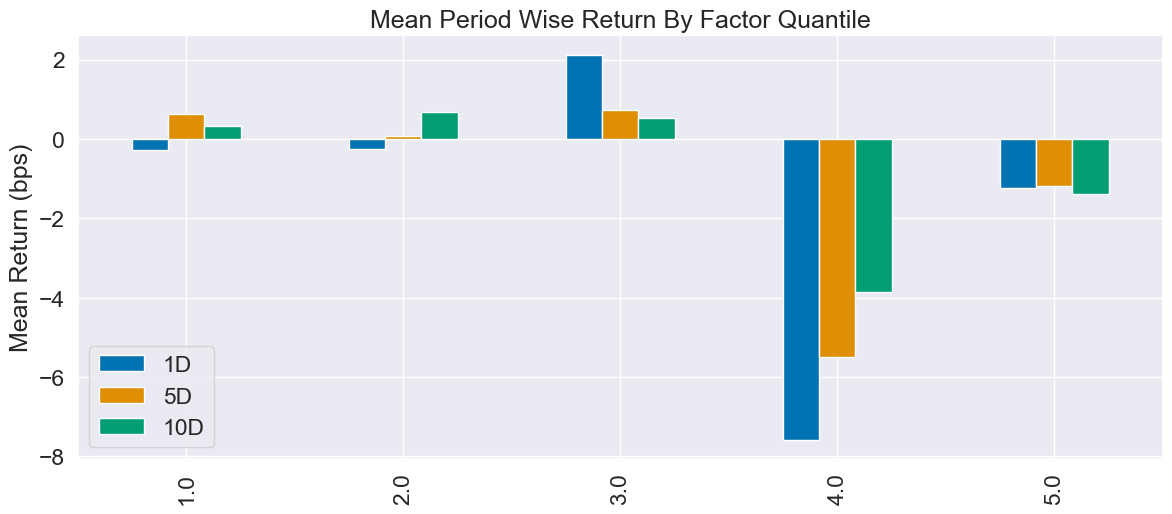

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-9.999987e-01,-2.267418e-13,-6.330783e-02,1.908938e-01,8748,20.313480
2.0,-5.543683e-06,-3.363825e-30,-1.100830e-08,1.397090e-07,8578,19.918728
3.0,-1.776314e-15,0.000000e+00,-3.200275e-18,5.138062e-17,10893,25.294323
4.0,-2.871214e-39,1.705813e-12,4.091746e-16,2.409148e-14,6266,14.550099
5.0,1.466503e-53,9.999995e-01,2.316413e-02,1.165039e-01,8580,19.923372


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.035,-0.130,-0.060
beta,0.012,0.073,0.091
Mean Period Wise Return Top Quantile (bps),-1.240,-1.176,-1.397
Mean Period Wise Return Bottom Quantile (bps),-0.286,0.622,0.328
Mean Period Wise Spread (bps),-0.954,-1.748,-1.638


<Figure size 640x480 with 0 Axes>

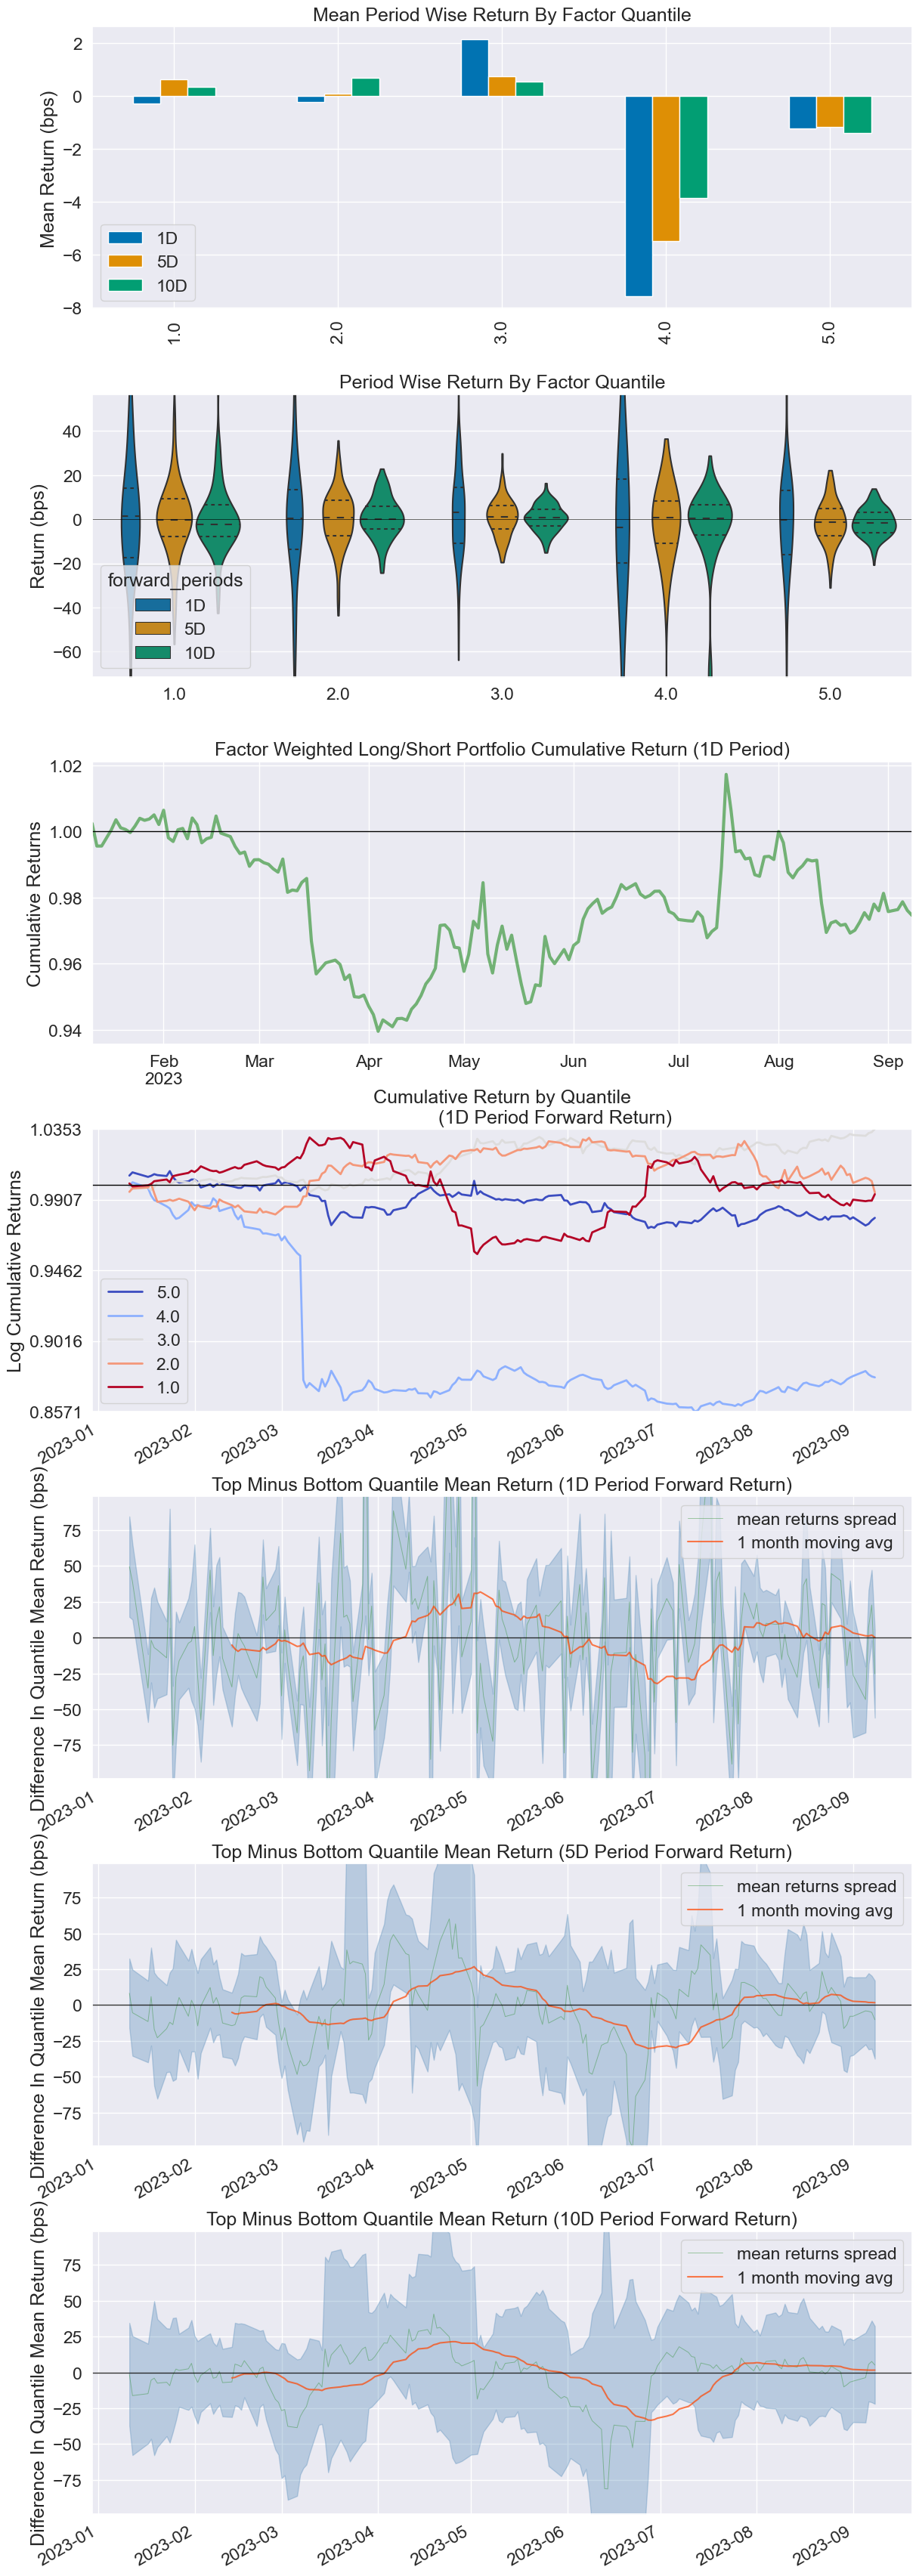

Information Analysis


,1D,5D,10D
IC Mean,-0.007,-0.010,-0.011
IC Std.,0.065,0.069,0.068
Risk-Adjusted IC,-0.104,-0.147,-0.169
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


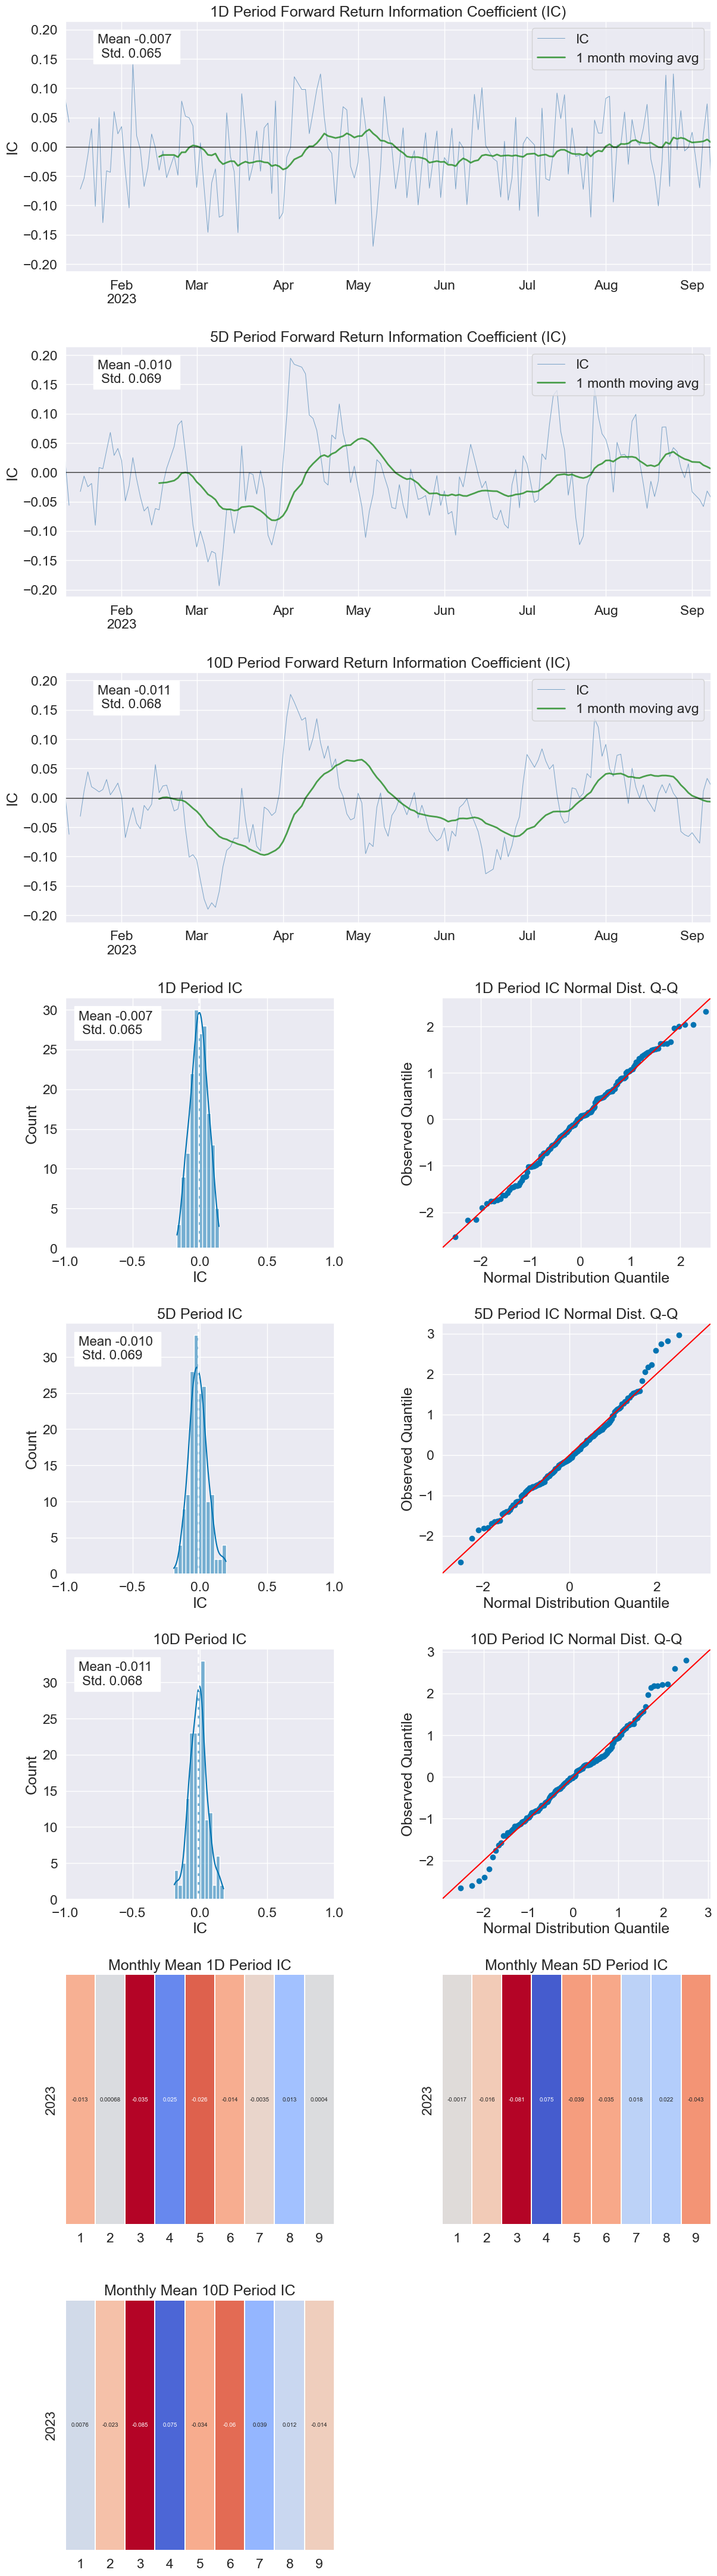

Turnover Analysis


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/alphalens/utils.py:929: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


,1D,5D,10D
Quantile 1.0 Mean Turnover,0.040,0.182,0.335
Quantile 2.0 Mean Turnover,0.038,0.160,0.300
Quantile 3.0 Mean Turnover,0.024,0.084,0.149
Quantile 4.0 Mean Turnover,0.046,0.132,0.187
Quantile 5.0 Mean Turnover,0.021,0.088,0.152


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.972,0.871,0.77


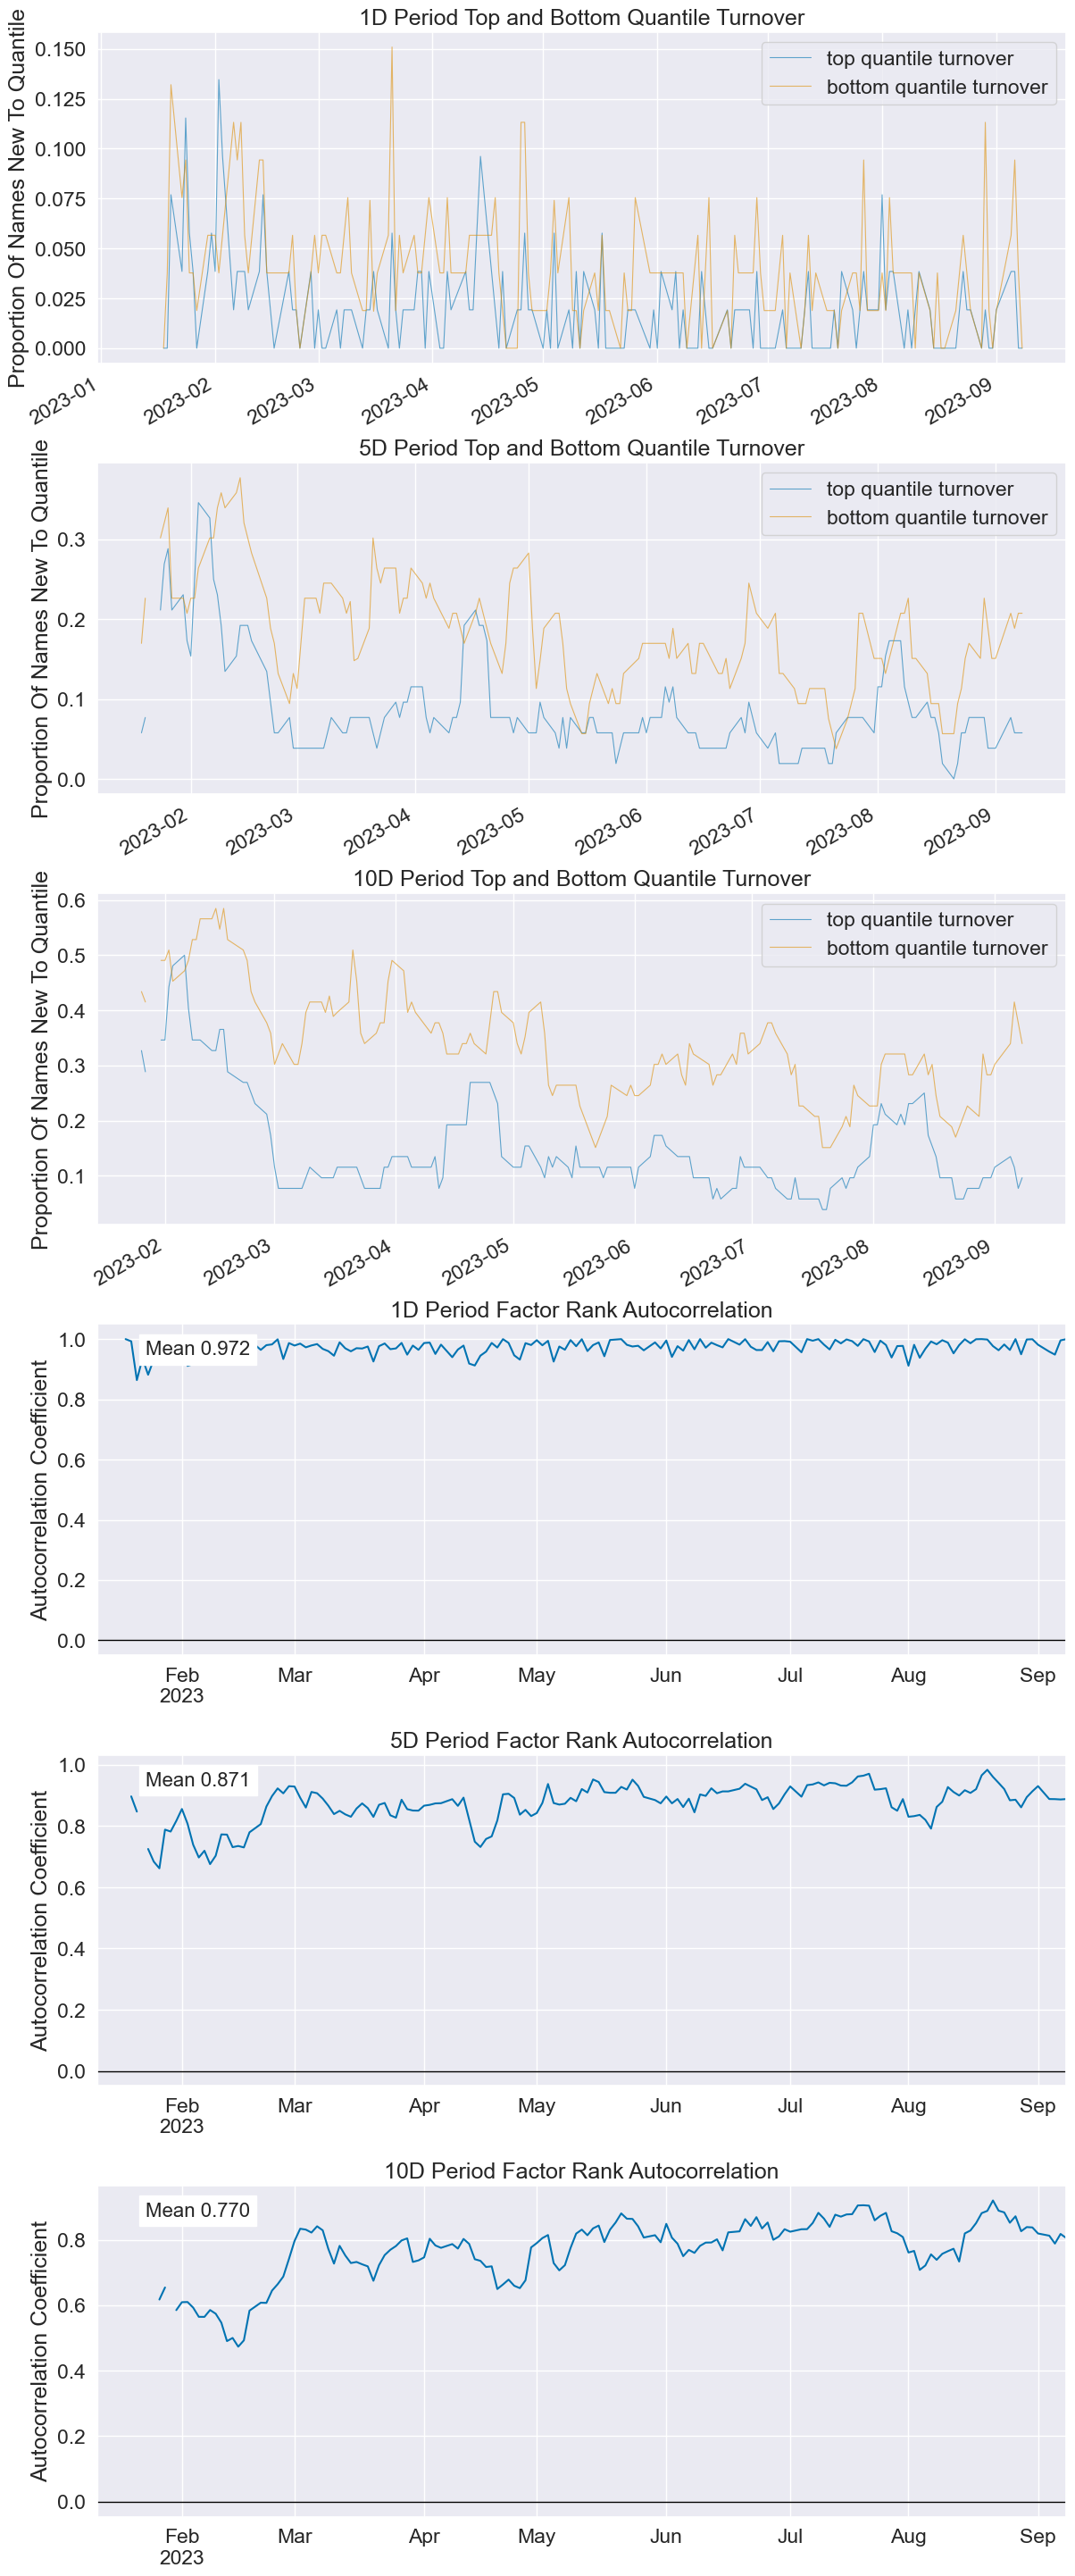

In [355]:
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=merged_data['sentiment_score'],
    prices=prices,
    periods=(1,5,10),
    quantiles= 5,
    bins=None,
    max_loss=0.73
)

factor_data

al.tears.create_summary_tear_sheet(factor_data)

al.tears.create_full_tear_sheet(factor_data)



### Short Long Portfolio Return

In [ ]:
mean_return_by_q.loc[5]-mean_return_by_q.loc[1]